# Energy A.I. Hackathon 2021 - Darcy Analytics

#### Authors: Barun Das (MS/Ph.D.), Mark Zhao (MS), Rebecca Lin (BS),  Mohmed H.K. Abdelfatah (Ph.D.), Hildebrand Department of Petroleum and Geosystems Engineering, Oden Institute for Computational Engineering and Sciences, Walker Department of Mechanical Engineering, Jackson School of Geosciences respectively
 

#### The University of Texas at Austin, Austin, Texas USA 
___

### Executive Summary 

Utilizing physics-informed machine learning and data science, we need to predict estimates and uncertainty models for cumulative oil 3 year production for 10 unproduced wells. To do so, Darcy Analytics integrated data science with domain expertise. Throughout the hackathon, Darcy Analytics, learned that it was necessary to remove communication and technical barriers between geologists and engineers. Going forward, Darcy Analytics recommends machine learning methodologies to enhance forecasting workflows across organizations.

___

### Workflow Goal

Workflow goals included fulfilling any unfilled features, including permeability, before searching for and verifying a machine learning algorithm for a prepared dataset and identifying uncertainty.
___

### Workflow Steps 

1. **Data Exploration** - Investigating data and plots based off of given datasets
2. **Feature Ranking** - Searching for features that have the most information about oil production and permeability
3. **Data Preparation** - Imputing missing data for all features
4. **Geological Modelling** - Investigating 2D/3D maps of wells and fault analysis
5. **Machine Learning** - Modelling oil recovery with an artificial neural network that considers the petrophysical properties of wellbores measured at depth
6. **Uncertainty Quantification** - Finding the amount of uncertainty the solution contains

$\ldots$


### Import Packages

In [1]:
import os                                                   # to set current working directory 
import numpy as np                                          # ndarrays for gridded data
import pandas as pd                                         # DataFrames for tabular data
import matplotlib.pyplot as plt                             # for visualizing data
from sklearn.impute import KNNImputer                       # for K Nearest Neighbors package
import seaborn as sns                                       # for visualizing data with Seaborn
from sklearn.preprocessing import StandardScaler            # to scale data
from scipy import stats                                     # standardizing features to unit variance
from sklearn.linear_model import LinearRegression           # ordinary least squares linear regression
from scipy import linalg                                    # implementing linear algebra equations

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer   # asking for multivariate inputer 
from sklearn.impute import SimpleImputer                    # imputation transformer
from sklearn.impute import IterativeImputer                 # multivariate inputer
from sklearn.linear_model import BayesianRidge              # fitting Bayesian ridge model
from sklearn.tree import DecisionTreeRegressor              # Decision Tree Regressor model
from sklearn.ensemble import ExtraTreesRegressor            # Extra Trees Regressor model
from sklearn.neighbors import KNeighborsRegressor           # K Nearest Neighbors Regressor model
from sklearn.pipeline import make_pipeline                  # creating Pipeline from estimators
from sklearn.pipeline import Pipeline                       # chaining transformers/estimators
from sklearn.model_selection import cross_val_score         # evaluating score via cross-validation
from sklearn.decomposition import PCA                       # Principal component analysis (PCA)

import tensorflow as tf                                     # open source machine learning platform

import subprocess                                           # spawn new processes
import pickle                                               # object hierarchy convert to byte stream
import datetime                                             # manipulating date/time values
from tensorflow import keras                                # Keras API for Tensorflow
from sklearn.model_selection import train_test_split        # split arrays/matricies into train/test
from sklearn.preprocessing import MinMaxScaler              # Transform features via scaling to range
from sklearn.compose import ColumnTransformer               # applies transformer to columns

from sklearn.preprocessing import FunctionTransformer       # construct transformer from callable
from sklearn.base import BaseEstimator                      # all estimators available from scikit
from sklearn.base import TransformerMixin                   # mixin class for transformers

from sklearn.compose import make_column_transformer         # constructs columns transformers

import geostatspy.GSLIB as GSLIB                            # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                      # GSLIB methods convert to Python   
import math                                                 # trigonometry, etc.
import random                                               # random values
from mpl_toolkits.mplot3d import Axes3D                     # adding labels to 3D plots

### Load Data

The following workflow applies the .csv file 'wellbore_data_producer_wells.csv' and 'production_history.csv', a dataset provided for the PGE Energy A.I. Hackathon 2021 hosted by Dr. Michael Pyrcz and Dr. John Foster, Architects: Honggen Jo and Mingyuan Yang, Sponsor: Prof. Jon Olson, and the Hildebrand Department of Petroleum and Geosystems Engineering Organization and Student Engagement: Gabby Banales and Sara Hernando. 

We will work with the following features:

* **Porosity** - fraction of rock void in units of percentage
* **Permeability** - quality of fluid flow through material in milliDarcy
* **Acoustic impedence** - amount of sonic resistance of material in units of $kg/m^2s*10^3$
* **Density** - degree of compactness of material in units of $g/cm^3$
* **Compressible Velocity** - maximum achieveable velocity of material in units of $m/s$
* **Young's Modulus** - measurement of material to withstand change under stress/strain in units of $GPa$
* **Shear Velocity** - material's resistance to shear flow in units of $m/s$
* **Shear Modulus** - material's response to shear stress in units of $GPa$

In [5]:
# Read producer file
prod = pd.read_csv("https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/wellbore_data_producer_wells.csv?token=AN5MCLBHM2IYJT6OO42JN43AQDE4U")  # read a .csv file in as a DataFrame
# Read cumulative oil file
cumoil = pd.read_csv('https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/production_history.csv?token=AN5MCLGECACCOYCJDAQCPYTAQDFCE')

### Functions

The following functions will be used in the workflow.
Develop Functions for Partial Correlation and Semipartial Correlation.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy) and Fabian Pedregosa-Izquierdo from Dr. Pyrcz's PGE383 Subsurface Data Analytics course regarding partial correlation coefficients. Original code can be found in the GitHub under the title "SubsurfaceDataAnalytics_Feature_Ranking.ipynb".

In [3]:
def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

### Data Exploration

Porosity Distribution Plot

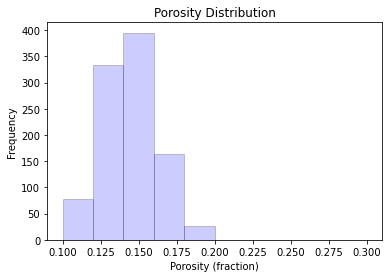

In [7]:
plt.hist(prod['Porosity, fraction'],color='blue',edgecolor='black',alpha=0.2,bins=10,range = [0.10,0.30])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency')  # add x and y axes labels
plt.title('Porosity Distribution')                          # add a title to the plot
plt.show()                                                  # show the plot

Combining Production & Cumulative Oil datasets; 
Instantiating scalar class and fit on data; pairplot

In [9]:
# Join on Well_ID (Left outer join)
df = pd.merge(prod, cumoil, on='Well_ID',how='left')


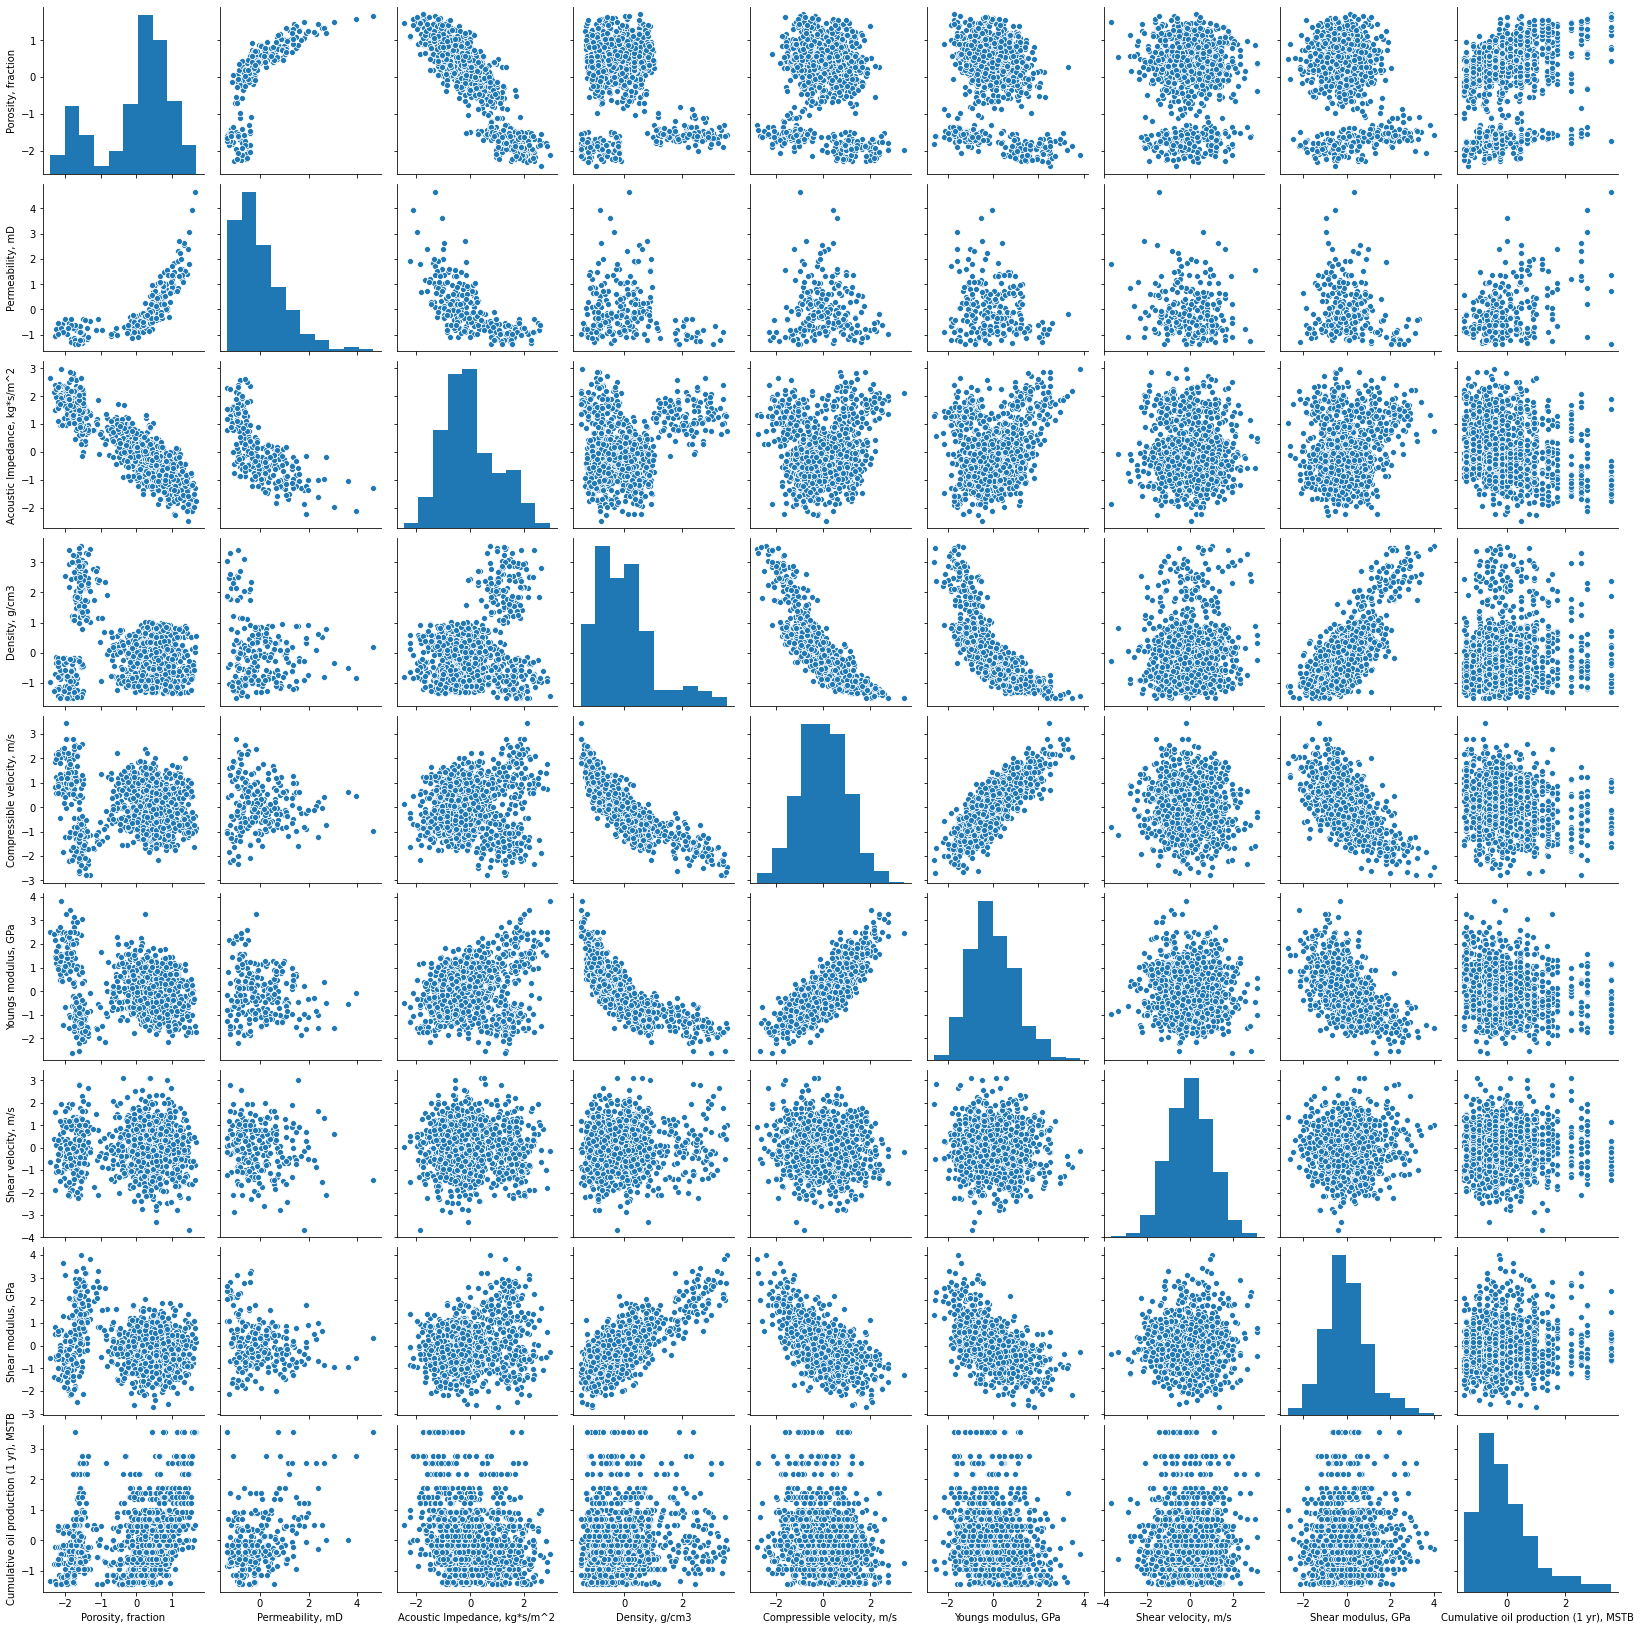

In [10]:
# Plot pairplot
df2 = df.drop(['Well_ID','Rock facies'],axis=1)
df2 = df2.iloc[:,3:-5]
# Standardize fetures before plotting
scaler = StandardScaler()
# Plot
df2_std = scaler.fit_transform(df2)
df2_std = pd.DataFrame(df2_std, columns=df2.columns)
sns.pairplot(df2_std, vars=df2_std.columns, markers = "o")

### Feature Ranking

Summary:
We rank features according to predict potential for cumulative oil production and permeability.

For permeability: Porosity, Young's modulus and Compression velocity may contain the most information.
For cumulative oil production (1 yr): Permeability, Shear Modulus, and Young's modulus contain much information.
Facies data not considered.

Performing covariance calculations, correlation measurements, Spearman Rank Coefficient

In [19]:
covariance = df2.cov().loc[:,['Permeability, mD','Cumulative oil production (1 yr), MSTB']]
std_corr = df2_std.corr().loc[:,['Permeability, mD','Cumulative oil production (1 yr), MSTB']]

stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(df2_std, nan_policy='omit')

stand_rank_correlation = pd.DataFrame(stand_rank_correlation, columns=df2_std.columns, index=df2_std.columns)
tmp = stand_rank_correlation.loc[:,['Permeability, mD','Cumulative oil production (1 yr), MSTB']]
tmp.sort_values(by=['Cumulative oil production (1 yr), MSTB'], ascending=False)

,"Permeability, mD","Cumulative oil production (1 yr), MSTB"
"Cumulative oil production (1 yr), MSTB",0.346120,1.000000
"Permeability, mD",1.000000,0.346120
"Porosity, fraction",0.890404,0.315930
"Shear modulus, GPa",-0.166004,0.082534
"Density, g/cm3",-0.094427,0.081487
"Shear velocity, m/s",-0.112821,0.025137
"Compressible velocity, m/s",-0.003052,-0.171612
"Youngs modulus, GPa",-0.132961,-0.195970
"Acoustic Impedance, kg*s/m^2",-0.712823,-0.236079


Permeability, Porosity and Acoustic Impedance best linear relationship with cumulative oil.  
Porosity and Acoustic Impedance best linear relationship with permeability.
Best monotonic relationship with Cumu Oil: Perm, Por, Youngs Modulus  
Best monotonic relationship with Perm: Por, AI  
Caution: Omit NaNs

Calculate the partial correlation

In [12]:
std_partial_correlation = partial_corr(df2_std.dropna()) # calculate the partial correlation coefficients

std_partial_correlation = pd.DataFrame(std_partial_correlation, columns=df2_std.columns, index=df2_std.columns)
tmp = std_partial_correlation.loc[:,['Permeability, mD','Cumulative oil production (1 yr), MSTB']]
tmp.sort_values(by=['Cumulative oil production (1 yr), MSTB'], ascending=False)

,"Permeability, mD","Cumulative oil production (1 yr), MSTB"
"Cumulative oil production (1 yr), MSTB",0.347752,1.000000
"Permeability, mD",1.000000,0.347752
"Shear modulus, GPa",-0.063833,0.192000
"Youngs modulus, GPa",-0.109186,0.109570
"Shear velocity, m/s",-0.062882,0.082913
"Porosity, fraction",0.406569,0.038917
"Density, g/cm3",-0.042932,0.032057
"Acoustic Impedance, kg*s/m^2",-0.025310,0.026997
"Compressible velocity, m/s",0.061717,-0.085011


Best relationship for Cumulative: Perm, Shear, Youngs  
Best relationship for Permeability: Por, Youngs  
Caution: Drop NaN

Calculate the Semipartial Correlation

In [13]:
std_semipartial_correlation = semipartial_corr(df2_std.dropna()) # calculate the partial correlation coefficients
std_semipartial_correlation = pd.DataFrame(std_semipartial_correlation, columns=df2_std.columns, index=df2_std.columns)
tmp = std_semipartial_correlation.loc[:,['Permeability, mD','Cumulative oil production (1 yr), MSTB']]
tmp.sort_values(by=['Cumulative oil production (1 yr), MSTB'], ascending=False)

,"Permeability, mD","Cumulative oil production (1 yr), MSTB"
"Cumulative oil production (1 yr), MSTB",0.233757,1.000000
"Permeability, mD",1.000000,0.233757
"Shear modulus, GPa",-0.038301,0.117284
"Shear velocity, m/s",-0.040016,0.078532
"Youngs modulus, GPa",-0.071379,0.042513
"Porosity, fraction",0.200398,0.016493
"Density, g/cm3",-0.029065,0.012323
"Acoustic Impedance, kg*s/m^2",-0.016467,0.010727
"Compressible velocity, m/s",0.039912,-0.044701


Best for Cumu Oil: Perm, Shear   
Best for Perm: Por  
Caution: Drop NaN

#### Feature Ranking Plot for Permeability

Understand the covariance attributes, Drop certain attributes for the covariance and features

In [22]:
# Define labels
features = ['Por','AI','Dens','V_c','Y_mod','V_sh','Sh_mod']

Create the covariance plot

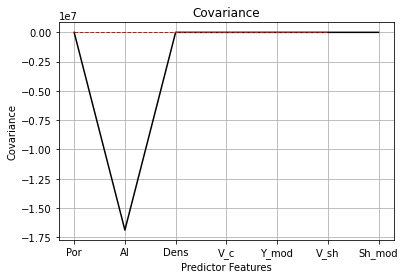

In [23]:
plt.plot(features,
         covariance.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
#plt.ylim(-5000,5000)
plt.grid(True)

Plot the Correlation Coefficient

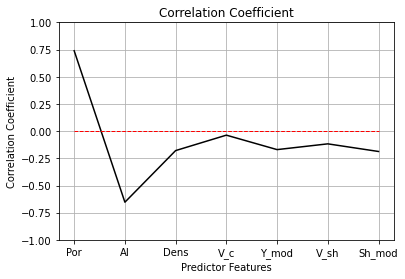

In [24]:
plt.plot(features,
         std_corr.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

Drop certain features from the standard rank correlation & Make plots for the Rank Correlation Coefficient

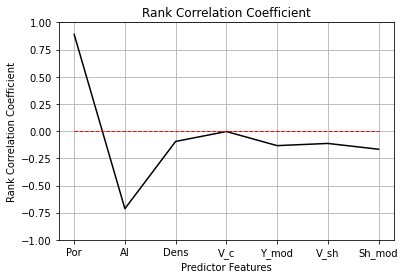

In [29]:
stand_rank_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD']
plt.plot(features,
        stand_rank_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'], color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)


Drop features from the Standard Partial Correlation & Plot the Partial Correlation Coefficient

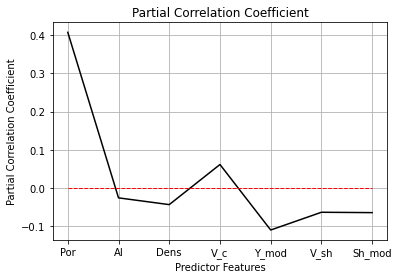

In [30]:
std_partial_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD']

plt.plot(features,
         std_partial_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.grid(True)

Drop values from the Semipartial Correlation & Create the semipartial correlation plot

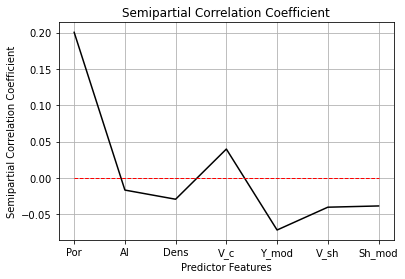

In [31]:
std_semipartial_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD']

plt.plot(features,
         std_semipartial_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.grid(True)

Create plots for Covariance, Correlation Coefficient, Rank Correlation Coefficient, Partial Correlation Coefficient, and Semipartial Correlation Coefficient

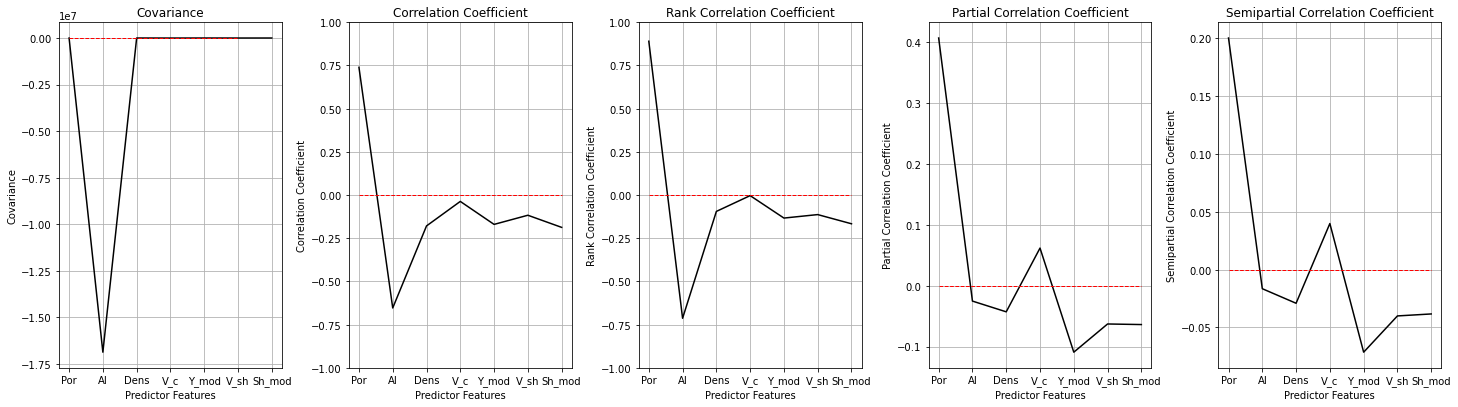

<Figure size 432x288 with 0 Axes>

In [32]:

plt.subplot(151)
plt.plot(features,
         covariance.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
#plt.ylim(-5000,5000)
plt.grid(True)

plt.subplot(152)
plt.plot(features,
         std_corr.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,
         stand_rank_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)


plt.subplot(154)
plt.plot(features,
         std_partial_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.grid(True)

plt.subplot(155)
plt.plot(features,
         std_semipartial_correlation.drop(['Permeability, mD','Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Permeability, mD'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()
plt.clf()

Drop the covariance values & Create plots for Covariance, Correlation Coefficient, Rank Correlation Coefficient, Partial Correlation Coefficient, and Semipartial Correlation Coefficient

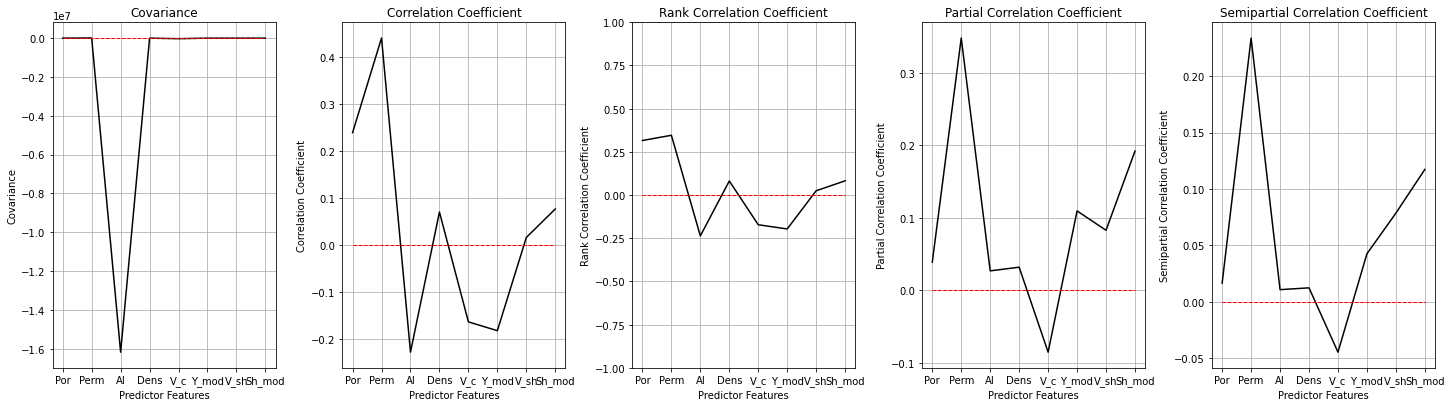

In [33]:
covariance.drop(['Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Cumulative oil production (1 yr), MSTB'],

t='Cumulative oil production (1 yr), MSTB'
features = ['Por','Perm','AI','Dens','V_c','Y_mod','V_sh','Sh_mod']
plt.subplot(151)
plt.plot(features,
         covariance.drop(['Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Cumulative oil production (1 yr), MSTB'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
#plt.ylim(-5000,5000)
plt.grid(True)

plt.subplot(152)
plt.plot(features,
         std_corr.drop(['Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Cumulative oil production (1 yr), MSTB'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
#plt.ylim(-5000,5000)
plt.grid(True)

plt.subplot(153)
plt.plot(features,
         stand_rank_correlation.drop(['Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Cumulative oil production (1 yr), MSTB'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)


plt.subplot(154)
plt.plot(features,
         std_partial_correlation.drop(['Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Cumulative oil production (1 yr), MSTB'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.grid(True)

plt.subplot(155)
plt.plot(features,
         std_semipartial_correlation.drop(['Cumulative oil production (1 yr), MSTB'],axis=0).loc[:,'Cumulative oil production (1 yr), MSTB'],
         color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

### Data Preparation
 
Objective: Impute missing data for all features except permeability.  
Why: PCA and ANN require complete data.  
How: We rank impute methods with 5-fold cross-validation evaluated by Bayesian Ridge.  
Conclusion: Summary: We select KNN to impute all features, based on rank impute methods with 5-fold cross-validation evaluated by Bayesian Ridge. 

Select the relevant attributes (columns) to impute

In [34]:
X = df.iloc[:,4:13].copy()
X.drop(['Rock facies'],axis=1,inplace=True)
X_coln = X.columns
X.head()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,0.13330,NaN,6981171.853,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,0.13865,NaN,7234748.871,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,0.14638,NaN,7157383.755,1.991045,3462.569030,28.232152,1636.279139,NaN
3,NaN,NaN,NaN,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,0.14993,NaN,NaN,1.664371,3919.585777,NaN,1636.846284,5.277834


Select label, the 3-year cumulative oil prod

<AxesSubplot:>

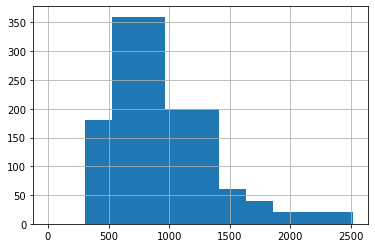

In [36]:
# Get histogram for label
y = df.loc[:,'Cumulative oil production (3 yr), MSTB'].copy()
y_name = y.name
y.hist()
# should be log transformed
y_log = np.log(y)
y_log.hist()

Standardize, also for KNN imputation

In [38]:
# Instantiate standard scaler transformers
std_scaler_X = StandardScaler()
std_scaler_y = StandardScaler()
X_std = std_scaler_X.fit_transform(X)
y_std = std_scaler_y.fit_transform(np.array(y).reshape(-1,1))

Estimate score after simple imputation (mean and median strategies)

In [39]:
N_SPLITS = 5
br_estimator = BayesianRidge()
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_std, y_std, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )
# Bayesian ridge scores
score_simple_imputer

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

,mean,median
0,-0.517795,-0.517711
1,-0.708358,-0.708734
2,-1.136502,-1.140633
3,-1.182870,-1.187778
4,-1.156771,-1.156434


Estimate the score after iterative imputation of the missing values with different estimators

In [40]:
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_std, y_std, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=10)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_std, y_std, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\linear_model\_bayes.py", line 193, in fit
    X, y = self._validate_data(X, y, dtype=np.float64, y_numeric=True)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Now use KNeighbors in IterativeImputer & Define a list of estimators

In [80]:
estimators = [
    KNeighborsRegressor(n_neighbors=i) for i in range(1,20)
]

# Get scores form each imputation method
score_iterative_imputer=pd.DataFrame().copy()
for impute_estimator,i in zip(estimators,range(len(estimators))):
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer['n={}'.format(i+1)] = \
        cross_val_score(
            estimator, X_std, y_std, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\im

In [84]:
# Show s8 neighbours best score
score_iterative_imputer.mean(axis=0)

n=1    -0.933301
n=2    -0.912331
n=3    -0.909894
n=4    -0.907658
n=5    -0.906602
n=6    -0.909198
n=7    -0.903095
n=8    -0.902952
n=9    -0.906996
n=10   -0.906969
n=11   -0.906369
n=12   -0.907642
n=13   -0.907794
n=14   -0.909170
n=15   -0.910414
n=16   -0.910561
n=17   -0.910150
n=18   -0.908443
n=19   -0.908649
dtype: float64

Check if iterative imputer works, inverse standardize to get actual values, Restore column names

In [43]:
imp = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=8))
X_full_std =imp.fit_transform(X_std,y_std)
X_full = std_scaler_X.inverse_transform(X_full_std)
X_full = pd.DataFrame(X_full, columns=X_coln)
X_full.head()

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,0.133300,128.097998,6.981172e+06,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,0.138650,98.184226,7.234749e+06,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,0.146380,98.627579,7.157384e+06,1.991045,3462.569030,28.232152,1636.279139,6.458443
3,0.141716,128.495093,7.230613e+06,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,0.149930,120.947044,7.177349e+06,1.664371,3919.585777,30.482507,1636.846284,5.277834


Sanity check on X_full: No impossible values (Ex: Negatives). Verify all missing values filled.

In [44]:
X_full.describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.128199,108.997465,7.322775e+06,2.042147,3697.712144,27.311022,1675.223964,5.752435
std,0.035387,59.517569,3.058621e+05,0.412723,718.741864,5.414508,95.085676,1.483936
min,0.040270,2.214604,6.559277e+06,1.421943,1661.828496,13.205134,1307.887097,1.650985
25%,0.117070,63.786453,7.114410e+06,1.728960,3189.904778,23.442919,1615.680398,4.777528
50%,0.138020,104.356596,7.270281e+06,1.975040,3673.863629,26.756913,1674.110346,5.599665
75%,0.151885,138.299071,7.482806e+06,2.212782,4212.620158,30.928539,1735.942264,6.541508
max,0.188910,489.219402,8.249272e+06,3.530373,6179.653016,48.123292,1989.829247,11.820038


Compare to original features

In [45]:
X_full.describe()-X.describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,192.000000,1.176000e+03,103.000000,212.000000,184.000000,1.990000e+02,190.000000,1.750000e+02
mean,0.000454,-3.185274e+00,-3010.760558,-0.010373,9.054291,2.214487e-02,-0.934111,-2.046664e-04
std,-0.000633,-2.137687e+01,-4250.478932,-0.004899,-8.474374,-1.010056e-02,-5.544418,-3.476305e-02
min,0.000000,4.440892e-16,0.000000,0.000000,0.000000,-1.776357e-15,0.000000,4.440892e-16
25%,0.003117,1.224547e+01,3354.161750,-0.005092,11.515291,-2.361897e-02,6.752089,2.005342e-02
50%,0.000525,1.037587e+01,-4052.785188,-0.013502,9.666803,1.094477e-01,-0.726228,-1.060188e-02
75%,-0.000440,-1.628582e+01,-20572.581500,-0.016725,-2.304808,5.391005e-02,-10.138987,-5.899535e-02
max,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00


Compare before and after impute
Confirm that std and meand don't change too much

In [46]:
pd.DataFrame(X_full_std, columns=X.columns).describe()-pd.DataFrame(X_std, columns=X.columns).describe()

,"Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,192.000000,1176.000000,103.000000,212.000000,184.000000,199.000000,190.000000,175.000000
mean,0.012602,-0.039445,-0.009712,-0.024849,0.012455,0.004084,-0.009286,-0.000135
std,-0.017585,-0.264723,-0.013711,-0.011736,-0.011658,-0.001863,-0.055119,-0.022899
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.086584,0.151643,0.010820,-0.012197,0.015841,-0.004356,0.067125,0.013209
50%,0.014581,0.128491,-0.013074,-0.032343,0.013298,0.020184,-0.007220,-0.006984
75%,-0.012220,-0.201677,-0.066364,-0.040065,-0.003171,0.009942,-0.100795,-0.038861
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### PCA
Plot explained variance ratio vs number of dimensions kept. Select 4 dimensions as tradeoff between explained variance and number of dimensions. Fewer dimensions is better.

Explained Variance by Dimension:
1 0.4465345184860715
2 0.7719368693753033
3 0.8943350047555714
4 0.9383811879338769
5 0.9594882398851561
6 0.9784956231900706
7 0.9922261722971952
8 1.0


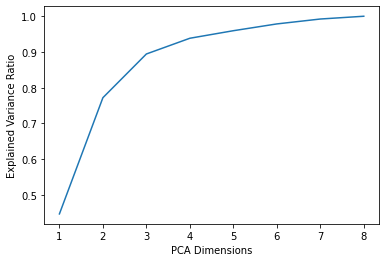

In [47]:
explained_variance=[]
print('Explained Variance by Dimension:')
for i in range(1,9):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_full_std)
    explained_variance.append(pca.explained_variance_ratio_.sum())
    print(i, pca.explained_variance_ratio_.sum())
    

plt.plot(range(1,9),explained_variance)
plt.xticks(np.arange(1, 9))
plt.xlabel('PCA Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.savefig('pca_expl_var.png')



Reduce to 4 dims, Min-max normalize the X_pca, Min-max normalize the y

array([[<AxesSubplot:title={'center':'Cumulative oil production (3 yr), MSTB'}>]],
      dtype=object)

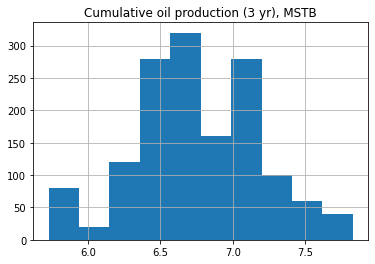

In [48]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_full_std)
pd.DataFrame(X_pca).describe()

x_min_max_scaler = MinMaxScaler()
X_pca_minmax = x_min_max_scaler.fit_transform(X_pca)
pd.DataFrame(X_pca_minmax).describe()

y_min_max_scaler = MinMaxScaler()
y_min_max = y_min_max_scaler.fit_transform(np.array(y).reshape(-1,1))
pd.DataFrame(y_min_max).describe()

pd.DataFrame(np.log(y)).hist()

Define transformation pipeline for label, features, prepare Y, For ANNs with Leaky ReLU, prefer no negative values, Search hyperparameters for best mode,. n_layers, n_nodes, training epochs.

### Geological Modelling

We visualize petrophysical data on a 2D map to better apply domain expertise:  
Show on 2D map the location of wells, overlay 2d plot with map data.  
Show 3D map  

In [52]:
# Clustered the .npz files into a single directory.
# dir_path points to this directory.
dir_path = r'C:\Users\win7\PycharmProjects\PGE_hack\darcy-analytics\2d_data'
# Get all file names within the dir
paths = [i for i in os.listdir(dir_path)]
paths

['2d_ai.npy',
 '2d_sandy_shale_propotion.npy',
 '2d_sand_propotion.npy',
 '2d_shale_propotion.npy',
 '2d_shaly_sand_propotion.npy',
 '2d_top_depth.npy']

In [53]:
# Load data into dictionary
data_dict = {}
for path in paths:
    data_array = np.load(os.path.join(dir_path,path))
    data_dict[path.split('.')[0]]=pd.DataFrame(data_array)
    

In [54]:
# Verify data shapes
for i in data_dict:
    print(i,data_dict[i].shape)

2d_ai (200, 200)
2d_sandy_shale_propotion (200, 200)
2d_sand_propotion (200, 200)
2d_shale_propotion (200, 200)
2d_shaly_sand_propotion (200, 200)
2d_top_depth (200, 200)


In [56]:
# Inspect
data_dict['2d_ai'].head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,7.330745e+06,7.331761e+06,7.334060e+06,7.338217e+06,7.342338e+06,7.343252e+06,7.344774e+06,7.349093e+06,7.350279e+06,7.354729e+06,...,7.506470e+06,7.502435e+06,7.501670e+06,7.500556e+06,7.497808e+06,7.497481e+06,7.499048e+06,7.497094e+06,7.497790e+06,7.498039e+06
1,7.333198e+06,7.336590e+06,7.340141e+06,7.344201e+06,7.346142e+06,7.346424e+06,7.346331e+06,7.349936e+06,7.353479e+06,7.356920e+06,...,7.503725e+06,7.500503e+06,7.499646e+06,7.497658e+06,7.495069e+06,7.493864e+06,7.493405e+06,7.492364e+06,7.493427e+06,7.491384e+06
2,7.339554e+06,7.339822e+06,7.346434e+06,7.346196e+06,7.349694e+06,7.348633e+06,7.348676e+06,7.353260e+06,7.355781e+06,7.358455e+06,...,7.500961e+06,7.497974e+06,7.495914e+06,7.495285e+06,7.492445e+06,7.491022e+06,7.491638e+06,7.490251e+06,7.490639e+06,7.489313e+06
3,7.343399e+06,7.346540e+06,7.349135e+06,7.350458e+06,7.350280e+06,7.351461e+06,7.352026e+06,7.355115e+06,7.357939e+06,7.359678e+06,...,7.497874e+06,7.494214e+06,7.492684e+06,7.490617e+06,7.487913e+06,7.487378e+06,7.487884e+06,7.486170e+06,7.485964e+06,7.485293e+06
4,7.349338e+06,7.350388e+06,7.351963e+06,7.352030e+06,7.352970e+06,7.354823e+06,7.354924e+06,7.357223e+06,7.359336e+06,7.362468e+06,...,7.495625e+06,7.492600e+06,7.490242e+06,7.488752e+06,7.485346e+06,7.484437e+06,7.485212e+06,7.484628e+06,7.485358e+06,7.484306e+06


2d_ai


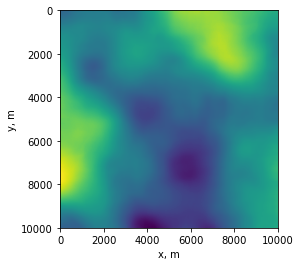

2d_sandy_shale_propotion


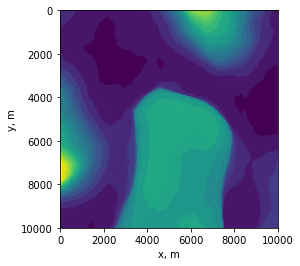

2d_sand_propotion


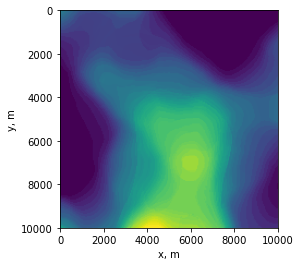

2d_shale_propotion


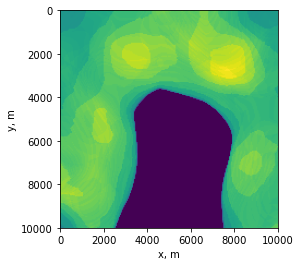

2d_shaly_sand_propotion


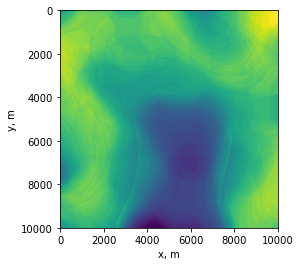

2d_top_depth


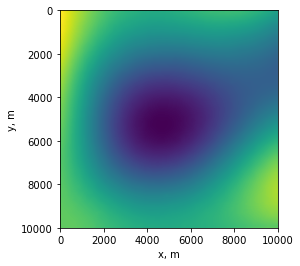

In [57]:
# Plot on map. Top left is (0,0)
for key in data_dict.keys():
    print(key)
    plt.imshow(data_dict[key], extent=[0,10000,10000,0])
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.savefig(key+'.png',bbox_inches='tight',dpi=600)
    plt.show()

#### Overlay well location on 2D maps


In [63]:
# Read pd
temp_path = r'C:\Users\win7\PycharmProjects\PGE_hack\darcy-analytics'
# Specify the data to overlay
producer_data = pd.read_csv(os.path.join(temp_path,'wellbore_data_producer_wells.csv'))
producer_data.head()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,NaN
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,NaN,1636.846284,5.277834


In [64]:
#loading preproduction data
preprod_data = pd.read_csv(r'https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/wellbore_data_preproduction_well.csv?token=AN5MCLBHSRE6U34AAFFYP5TAQR3S2')
preprod_data.iloc[:,1:4].head()

,"X, m","Y, m","Depth, m"
0,7925,5525,3050.51
1,7925,5525,3051.01
2,7925,5525,3051.51
3,7925,5525,3052.01
4,7925,5525,3052.51


In [65]:
# Select only x,y columns
prod_xy = producer_data[['X, m','Y, m']]

2d_ai


C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


2d_sandy_shale_propotion
2d_sand_propotion
2d_shale_propotion
2d_shaly_sand_propotion
2d_top_depth


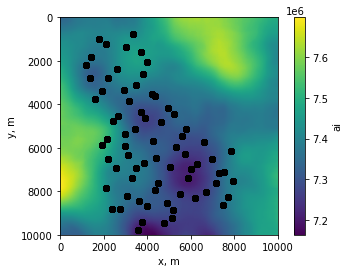

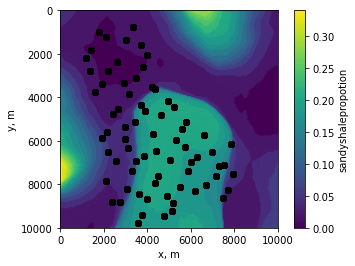

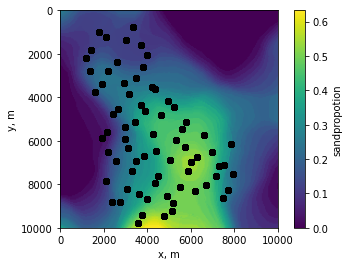

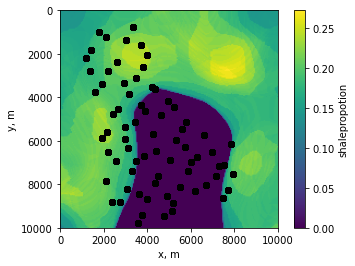

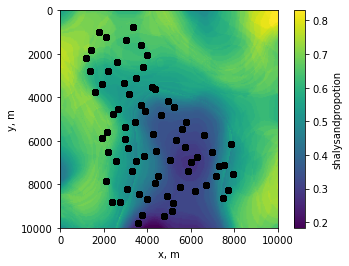

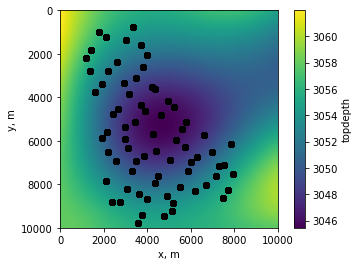

In [66]:
# Overlay on 2d maps
# Plot on map. Top left is (0,0)
for key in data_dict.keys():
    print(key)
    fig, ax = plt.subplots()
    pos = ax.imshow(data_dict[key], extent=[0,10000,10000,0])
    fig.colorbar(pos, ax=ax,label=''.join(key.split('_')[1:]))
    ax.scatter(prod_xy.iloc[:,0],prod_xy.iloc[:,1], color='black')
    
    ax.set_xlabel('x, m')
    ax.set_ylabel('y, m')
    fig.savefig(key+'_prod_wells.png',bbox_inches='tight',dpi=600)
    fig.show()

#### Load Preproduction Wells
Plot preproduction wells on 2D map.


In [67]:
# Read pd
temp_path = r'C:\Users\win7\PycharmProjects\PGE_hack\darcy-analytics'
# Specify the data to overlay
preproducer = pd.read_csv(os.path.join(temp_path,'wellbore_data_preproduction_well.csv'))
preproducer.head()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,Well_no_74,7925,5525,3050.51,NaN,NaN,7842692.077,Sandy shale,NaN,3387.576377,NaN,1646.603549,6.229941
1,Well_no_74,7925,5525,3051.01,0.09096,NaN,7807355.262,Shaly sandstone,1.872982,NaN,NaN,1465.051728,4.930174
2,Well_no_74,7925,5525,3051.51,0.05878,NaN,7864859.402,Sandy shale,3.187123,2660.306664,18.875428,1570.481116,7.202703
3,Well_no_74,7925,5525,3052.01,NaN,NaN,7309508.797,Shaly sandstone,2.058578,3285.615950,26.992396,1652.096739,6.486131
4,Well_no_74,7925,5525,3052.51,0.12285,NaN,7328552.658,Shaly sandstone,1.678339,4432.429019,35.261378,1697.320552,3.802001


2d_ai


C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


2d_sandy_shale_propotion
2d_sand_propotion
2d_shale_propotion
2d_shaly_sand_propotion
2d_top_depth


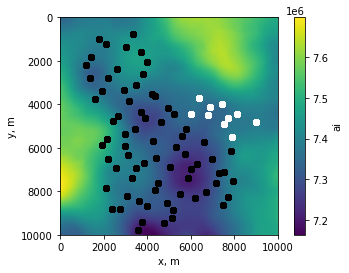

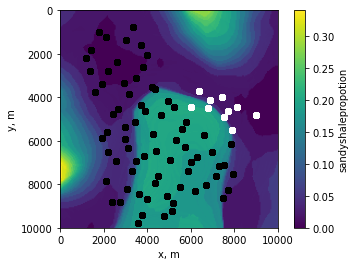

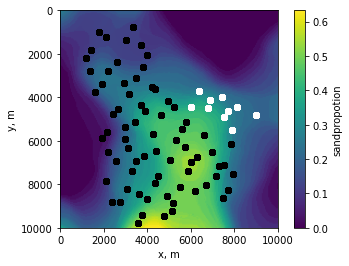

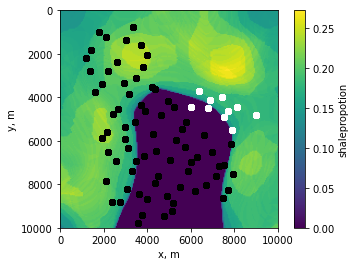

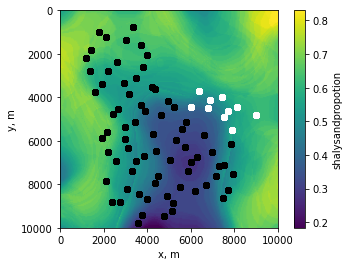

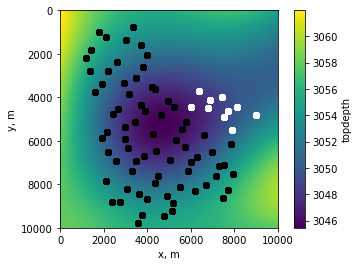

In [69]:
# Overlay on 2d maps
# Plot on map. Top left is (0,0)
for key in data_dict.keys():
    print(key)
    fig, ax = plt.subplots()
    pos = ax.imshow(data_dict[key], extent=[0,10000,10000,0])
    fig.colorbar(pos, ax=ax,label=''.join(key.split('_')[1:]))
    ax.scatter(prod_xy.iloc[:,0],prod_xy.iloc[:,1], color='black')
    ax.scatter(preproducer['X, m'],preproducer['Y, m'], color='white')
    
    ax.set_xlabel('x, m')
    ax.set_ylabel('y, m')
    fig.savefig(key+'_all_wells.png',bbox_inches='tight',dpi=600)
    fig.show()

In [70]:
# Use pyvista to make 3D surfaces
import pyvista as pv
from pyvista import examples
import numpy as np

In [72]:
# Get columns
x_top = data_dict['2d_top_depth'].columns
y_top = data_dict['2d_top_depth'].index

In [73]:
# Make meshgrid
x_top,y_top = np.meshgrid(x_top,y_top)

In [74]:
# Get coordinates
prod_xyz=producer_data.iloc[:,1:4]

In [75]:
# Make points
points = np.c_[prod_xyz.iloc[:,0],prod_xyz.iloc[:,1],prod_xyz.iloc[:,2]]
foo = pv.PolyData(points)


In [76]:
# Add preproduction points
preprod_xyz= preprod_data.iloc[:,1:4]

,"X, m","Y, m","Depth, m"
0,7925,5525,3050.51
1,7925,5525,3051.01
2,7925,5525,3051.51
3,7925,5525,3052.01
4,7925,5525,3052.51


In [77]:
# Meshgrid for contact surface, at -3067 m.
x_contact = np.linspace(0,10000,10)
y_contact = np.linspace(0,10000,10)
z_contact = -3067.4*np.ones((10,10))
x_contact, y_contact=np.meshgrid(x_contact,y_contact)

<IPython.core.display.Javascript object>


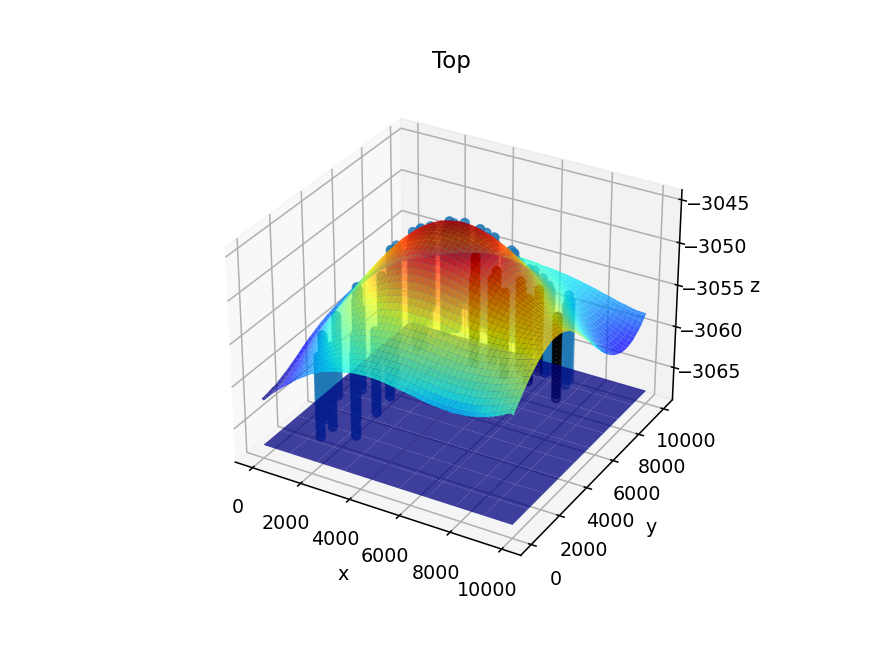

In [79]:
# Plot 3D interactive visualization
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(prod_xyz.iloc[:,0],prod_xyz.iloc[:,1],-prod_xyz.iloc[:,2], color='C0')
ax.scatter(preprod_xyz.iloc[:,0],preprod_xyz.iloc[:,1],-preprod_xyz.iloc[:,2],color='black')
ax.set_zlabel('z')
ax.set_xlabel('x')
ax.set_ylabel('y')

#ax2=fig.add_subplot(projection='3d')
#ax2 = plt.axes(projection='3d')

ax.plot_surface(x_top*50, y_top*50, -data_dict['2d_top_depth'],cmap='jet', edgecolor='none',alpha=.75)# Top
ax.plot_surface(x_contact, y_contact, z_contact,cmap='jet', edgecolor='none',alpha=.75)# Water-oil contact



#ax.scatter(prod_xy.iloc[:,0],prod_xy.iloc[:,1],-3045, color='black')
ax.set_title('Top')
fig.savefig('3D_wells_and_surface.png',dpi=200 )
fig.show()

### Machine Learning
#### Summary


We model oil recovery using an artificial neural network that considers the petrophysical properties of the wellbore, measured at each depth. Using our ANN, we predict the oil recovery at each depth interval, and aggregate these predictions to produce the mean oil recovery per well. The following outline the advantages of this approach:  

Predictions scale with well depth and new information. That is, there is no need to retrain the model if additional well log data comes is added, because the model outputs incremental recovery predictions for every new data point.

Predictions have less uncertainty, because there is no upscaling. Users can predict depth-dependent recovery estimates, and identify depth intervals of high production.

We choose the following depth-dependent numerical attributes as predictor features: Porosity, fraction	Permeability, mD	Acoustic Impedance, kg*s/m^2	Density, g/cm3	Compressible velocity, m/s	Youngs modulus, GPa	Shear velocity, m/s	Shear modulus, GPa.  

Label: Petrophysics-dependent cumulative oil recovery, MTSB, predicted for each depth and for each well.  

Below are the predictions:

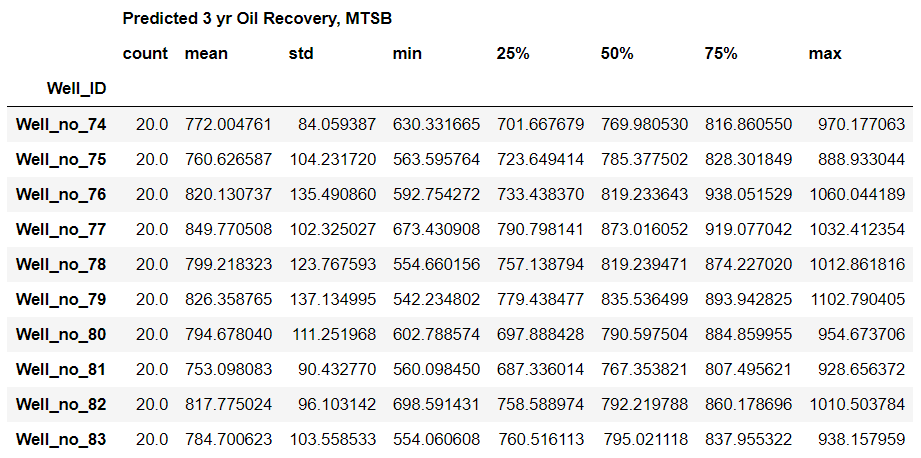

### Training Steps

We package feature and label transformations into pipelines, which sequentially perform the fit_transform method for each transformation.

For predictor features, we:  
Drop non predictor features from the input,  
Standardize all predictor features,    
Perform KNearestNeighbors with 8 neighbors,  
Normalize to 0-1 (minmax).   
 
For labels,  
Perform log transormation,    
Normalize to 0-1.    

ANN hyperparameters:  2 layers, 10 nodes each, 100 epochs.  

### Hyperparameter Choice Justification

Features selected by domain expertise. From data exploration, we saw that permeability values are very sparse, but highly predictive for cumulative oil production. Remaining features had abou 5-15% of values missing.  

Feature standardization is necessary for distance-based estimators, in this case KNN.  
Iterative imputation with KNN appeared a feasible solution to fill missing values. We tested 1-20 neighbors in 5-fold cross-validation scores evaluated by bayesian ridge.  

Next, the we perform PCA to reduce dimensionality, as higher dimensional data is harder to fit to a model. We test 1-8 dimensions, and found selected 4 dimensions and found that they were a good balance of explaine variance (93%) and few dimensions.  

We normalize to 0-1 to help train the ANN. The activation function, Leaky ReLU, may converge faster for strictly positive training data.  


For labels, the cumulative oil production at 3 years, we noticed the histogram distribution to be logarithmic. Therefore, we perform a log-transform to make the distribution symmetric, and roughly bell-shaped. This helps the model training.  

Then, we perform min-max normalization to 0-1.  


Lastly, we chose 2 layers, 10 nodes per layer, and trained for 100 epochs.  
We keep only 2 layers to reduce model variance, following the advice of the mentor Nkem.  

## Train with test-train split
Train model using the train data subset (90% of entire data) to find good hyperparameters. We found 2 layers, 10 nodes to be good. Model does not overfit, as the validation error does not exceed the train error.

In [91]:
# Re-import modules, to be safe
# Import all the good stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


import tensorflow as tf

import os
import pandas as pd
import tensorflow as tf
import subprocess
import pickle
import datetime
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer


In [92]:
# Read producer
prod = pd.read_csv("https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/wellbore_data_producer_wells.csv?token=AN5MCLBHM2IYJT6OO42JN43AQDE4U")
# Read cumulative oil
cumoil = pd.read_csv('https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/production_history.csv?token=AN5MCLGECACCOYCJDAQCPYTAQDFCE')

In [93]:
# Join on Well_ID (Left outer join)
df = pd.merge(prod, cumoil, on='Well_ID',how='left')
df.head()


,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Cumulative oil production (1 yr), MSTB","Cumulative oil production (2 yr), MSTB","Cumulative oil production (3 yr), MSTB","Cumulative Water production (1 yr), MSTB","Cumulative Water production (2 yr), MSTB","Cumulative Water production (3 yr), MSTB"
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717,450.98,684.2,847.33,494.89,1236.4,2108.7
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120,450.98,684.2,847.33,494.89,1236.4,2108.7
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,NaN,450.98,684.2,847.33,494.89,1236.4,2108.7
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763,450.98,684.2,847.33,494.89,1236.4,2108.7
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,NaN,1636.846284,5.277834,450.98,684.2,847.33,494.89,1236.4,2108.7


In [94]:
# Split test-train, set 10% aside as test set
df_train, df_test=train_test_split(df, test_size=0.1, random_state=42)

In [95]:
# Select label column.
y_train = df_train['Cumulative oil production (3 yr), MSTB'].copy()
y_test = df_test['Cumulative oil production (3 yr), MSTB'].copy()
y_full = df['Cumulative oil production (3 yr), MSTB'].copy()

In [96]:
# Reshape label column, because pipelines require 2D data.
y_train = np.array(y_train).reshape((-1,1))
y_test = np.array(y_test).reshape((-1,1))
y_full = np.array(y_full).reshape((-1,1))

In [97]:
# Create ANN model for oil recov
def model_construct(n_layers, n_nodes, n_inputs):
    '''
    n_layers
    n_nodes
    n_inputs: Dims of inputs, X_train_prepared.shape[1]
    '''
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=[n_inputs]))
    for _ in range(n_layers-1):
        model.add(tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(tf.keras.layers.Dense(1))

    # Remove lr if scheduler in use?
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
                  metrics=['mse', 'mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [113]:
# Store version info as file in directory
# Disabled, needs git
'''def get_git_revision_hash():
    return subprocess.check_output(['git', 'rev-parse', 'HEAD'])'''

"def get_git_revision_hash():\n    return subprocess.check_output(['git', 'rev-parse', 'HEAD'])"

In [114]:
# Function to train ANN model
def train_model(model,
                X,
                y,
                X_test,
                y_test,
                batch_size,
                n_layers,
                n_nodes,
                epochs,
                initial_epoch,
                log_save_dir,
                name_prefix):
    # Create Directory for Logs
    model_name = name_prefix+'_'+str(batch_size)+'_'+str(n_layers)+'_'+str(n_nodes)+'_'+str(epochs)+'_'
    logdir = log_save_dir + ".\\logs\\scalars\\" + model_name + str(
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    logdir = logdir
    if not os.path.exists(logdir):
        os.makedirs(logdir)
        print('New logdir created.')
        
    # Logs
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=0,  # How often to log histogram visualizations
        write_graph=True,
        update_freq='epoch',
        profile_batch=0,  # set to 0. Else bug Tensorboard not show train loss.
        embeddings_freq=0,  # How often to log embedding visualizations
    )
    
    # Early stop
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', min_delta=0.001, patience=3)

    # Save Checkpoint
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=logdir,  # +'.\\{epoch:.02d}-{mse:.2f}',
        verbose=1,
        save_weights_only=False,
        monitor='mse',  # Not sure
        mode='auto',
        save_best_only=True)
    
    # Disable, needs Git
    '''with open(logdir + '.\\version_info.txt', 'a', newline='') as file:
        file.write('model_name'+' '+str(get_git_revision_hash()) + '\n')'''

    # Train. History stores loss metrics per epoch
    history = model.fit(X, y, initial_epoch=initial_epoch, epochs=epochs,
                        callbacks=[tensorboard_callback, model_checkpoint_callback],
                        validation_data=(X_test, y_test),
                        shuffle=True,
                        batch_size=batch_size, verbose=2)

    # Save entire model with training config
    model.save(logdir + '.\\' + model_name + '{}'.format(str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))))
    
    return model

    endTime = datetime.datetime.now()
    print('Ended at ' + str(endTime))
    print('end')

In [115]:
# Define Transformers
# Select columns and standardize them. Drop all remaining.
std_scaler_X = StandardScaler()
select_and_std=make_column_transformer((std_scaler_X,[4,5,6,8,9,10,11,12]))

In [116]:
# Transformer for features, min-max normalize
x_min_max_scaler = MinMaxScaler()

In [117]:
# Custom log transformer
log_transformer = FunctionTransformer(np.log,np.exp, validate=True)

In [118]:
# Define transformation pipeline for label

label_pipe = Pipeline([
    ('select column and log transform', log_transformer)
])

In [119]:
# Define transformation pipeline for features
feature_pipe = Pipeline([
    ('Select_cols_and_std',select_and_std),
    ('Iterative_impute_KNN',IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=8))),
    ('PCA',PCA(n_components=4)),
    ('minmax',x_min_max_scaler)
])

In [120]:
# Fit transform predictor features
X_train_prepared=feature_pipe.fit_transform(df_train)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [121]:
# Transform test predictor features
X_test_prepared=feature_pipe.transform(df_test)

In [122]:
# Fit transform labels
y_train_prepared = label_pipe.fit_transform(y_train)

In [123]:
# Transform test labels
y_test_prepared = label_pipe.transform(y_test)

In [124]:
# Test Inverse transform the labels
temp=pd.DataFrame(label_pipe.inverse_transform(y_train_prepared))
temp.describe()

,0
count,1314.000000
mean,940.556910
std,428.179955
min,307.120000
25%,643.140000
50%,819.490000
75%,1185.400000
max,2514.500000


In [125]:
# Verify inverse transform for label is good. That is, the summary statistics are identical.
pd.DataFrame(y_train).describe()

,0
count,1314.000000
mean,940.556910
std,428.179955
min,307.120000
25%,643.140000
50%,819.490000
75%,1185.400000
max,2514.500000


In [126]:
# Compile ANN architecture (nodes, layers)
# Choose leaky ReLU arbitratily. Should have fast convergence.
# Search hyperparameters for best model. n_layers, n_nodes, training epochs.
n_layers=2
n_nodes=10
oilrecov3_model = model_construct(n_layers, n_nodes, X_train_prepared.shape[1])

In [127]:
log_save_dir=r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs'
name_prefix='dummy_oilrecov_nlayers{}_nodes{}_epochs{}_split_v4'.format(n_layers,n_nodes,50)
model = train_model(oilrecov3_model,
                X_train_prepared,
                y_train_prepared,
                X_test_prepared,
                y_test_prepared,                    
                batch_size=32,
                n_layers=n_layers,
                n_nodes=n_nodes,
                epochs=100,
                initial_epoch=0,
                log_save_dir=log_save_dir,
                name_prefix=name_prefix)

New logdir created.
Train on 1314 samples, validate on 146 samples
Epoch 1/100

Epoch 00001: mse improved from inf to 45.71536, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 2s - loss: 45.7154 - mse: 45.7154 - mae: 6.7466 - mean_absolute_percentage_error: 99.9271 - val_loss: 43.5013 - val_mse: 43.5013 - val_mae: 6.5816 - val_mean_absolute_percentage_error: 97.2874
Epoch 2/100

Epoch 00002: mse improved from 45.71536 to 38.58535, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Asse

Epoch 14/100

Epoch 00014: mse improved from 0.70881 to 0.69585, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.6958 - mse: 0.6958 - mae: 0.6618 - mean_absolute_percentage_error: 9.7779 - val_loss: 0.6853 - val_mse: 0.6853 - val_mae: 0.6650 - val_mean_absolute_percentage_error: 9.8120
Epoch 15/100

Epoch 00015: mse improved from 0.69585 to 0.68113, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-1

1314/1314 - 1s - loss: 0.5141 - mse: 0.5141 - mae: 0.5655 - mean_absolute_percentage_error: 8.3668 - val_loss: 0.5003 - val_mse: 0.5003 - val_mae: 0.5716 - val_mean_absolute_percentage_error: 8.4367
Epoch 28/100

Epoch 00028: mse improved from 0.51408 to 0.50104, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.5010 - mse: 0.5010 - mae: 0.5580 - mean_absolute_percentage_error: 8.2710 - val_loss: 0.4878 - val_mse: 0.4878 - val_mae: 0.5651 - val_mean_absolute_percentage_error: 8.3372
Epoch 29/100

Epoch 00029: mse improved from 0.50104 to 0.48896, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.3484 - mse: 0.3484 - mae: 0.4651 - mean_absolute_percentage_error: 6.9086 - val_loss: 0.3374 - val_mse: 0.3374 - val_mae: 0.4733 - val_mean_absolute_percentage_error: 6.9688
Epoch 42/100

Epoch 00042: mse improved from 0.34845 to 0.33893, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.3389 - mse: 0.3389 - mae: 0.4586 - mean_absolute_percentage_error: 6.8045 - val_loss: 0.3229 - val_mse: 0.3229 - val_mae: 0.4622 - val_mean_absolute_percentage_error: 6.8348
Epoch 43/10

Epoch 55/100

Epoch 00055: mse improved from 0.24610 to 0.23985, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.2399 - mse: 0.2399 - mae: 0.3880 - mean_absolute_percentage_error: 5.7644 - val_loss: 0.2233 - val_mse: 0.2233 - val_mae: 0.3808 - val_mean_absolute_percentage_error: 5.6580
Epoch 56/100

Epoch 00056: mse improved from 0.23985 to 0.23529, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-1

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.1919 - mse: 0.1919 - mae: 0.3493 - mean_absolute_percentage_error: 5.1949 - val_loss: 0.1708 - val_mse: 0.1708 - val_mae: 0.3291 - val_mean_absolute_percentage_error: 4.8704
Epoch 70/100

Epoch 00070: mse improved from 0.19187 to 0.18707, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.1871 - mse: 0.1871 - mae: 0.3464 - mean_absolute_percentage_error: 5.1674 - val_loss: 0.1752 - val_mse: 0.1752 - val_mae: 0.3340 - val_mean_absolute_percentage_error: 4.9024
Epoch 71/10

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910\assets
1314/1314 - 1s - loss: 0.1758 - mse: 0.1758 - mae: 0.3371 - mean_absolute_percentage_error: 5.0302 - val_loss: 0.1515 - val_mse: 0.1515 - val_mae: 0.3123 - val_mean_absolute_percentage_error: 4.6347
Epoch 86/100

Epoch 00086: mse did not improve from 0.17576
1314/1314 - 0s - loss: 0.1775 - mse: 0.1775 - mae: 0.3377 - mean_absolute_percentage_error: 5.0278 - val_loss: 0.1529 - val_mse: 0.1529 - val_mae: 0.3122 - val_mean_absolute_percentage_error: 4.6058
Epoch 87/100

Epoch 00087: mse improved from 0.17576 to 0.17511, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-113910
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_nlayers2_nodes10_epoc

### Train on Full Data
Repeat training on full data, with hyperparameters found in previous step. Validation mean absolute percent error: 4.5%.

In [128]:
# Fit transform predictor features
X_full_prepared=feature_pipe.fit_transform(df)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [129]:
# Transform test labels
y_full_prepared = label_pipe.transform(y_full)

In [130]:
# Transform test labels
y_full_prepared = label_pipe.transform(y_full)

In [131]:
# Compile ANN architecture (nodes, layers)
# Choose leaky ReLU arbitratily. Should have fast convergence.
# Search hyperparameters for best model. n_layers, n_nodes, training epochs.
n_layers=2
n_nodes=10
oilrecov3_model = model_construct(n_layers, n_nodes, X_train_prepared.shape[1])

In [132]:
log_save_dir=r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs'
name_prefix='dummy_oilrecov_log_nlayers{}_nodes{}_epochs{}_full'.format(n_layers,n_nodes,100)
model = train_model(oilrecov3_model,
                X_train_prepared,
                y_train_prepared,
                X_test_prepared,
                y_test_prepared,                    
                batch_size=32,
                n_layers=n_layers,
                n_nodes=n_nodes,
                epochs=100,
                initial_epoch=0,
                log_save_dir=log_save_dir,
                name_prefix=name_prefix)

New logdir created.
Train on 1314 samples, validate on 146 samples
Epoch 1/100

Epoch 00001: mse improved from inf to 37.90912, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 37.9091 - mse: 37.9091 - mae: 6.1358 - mean_absolute_percentage_error: 90.8446 - val_loss: 32.9322 - val_mse: 32.9322 - val_mae: 5.7221 - val_mean_absolute_percentage_error: 84.5460
Epoch 2/100

Epoch 00002: mse improved from 37.90912 to 27.07983, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 0.7825 - mse: 0.7825 - mae: 0.6959 - mean_absolute_percentage_error: 10.2534 - val_loss: 0.6367 - val_mse: 0.6367 - val_mae: 0.6453 - val_mean_absolute_percentage_error: 9.4360
Epoch 15/100

Epoch 00015: mse improved from 0.78250 to 0.75854, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 0.7585 - mse: 0.7585 - mae: 0.6859 - mean_absolute_percentage_error: 10.1022 - val_loss: 0.6122 - val_mse: 0.6122 - val_mae: 0.6315 - val_mean_absolute_percentage_error: 9.2447
Epoch 

Epoch 28/100

Epoch 00028: mse improved from 0.49614 to 0.47706, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 0.4771 - mse: 0.4771 - mae: 0.5462 - mean_absolute_percentage_error: 8.0973 - val_loss: 0.4194 - val_mse: 0.4194 - val_mae: 0.5237 - val_mean_absolute_percentage_error: 7.6654
Epoch 29/100

Epoch 00029: mse improved from 0.47706 to 0.46038, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_202104

1314/1314 - 1s - loss: 0.2818 - mse: 0.2818 - mae: 0.4195 - mean_absolute_percentage_error: 6.2432 - val_loss: 0.2577 - val_mse: 0.2577 - val_mae: 0.4130 - val_mean_absolute_percentage_error: 6.0654
Epoch 42/100

Epoch 00042: mse improved from 0.28184 to 0.27117, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 0.2712 - mse: 0.2712 - mae: 0.4117 - mean_absolute_percentage_error: 6.1078 - val_loss: 0.2415 - val_mse: 0.2415 - val_mae: 0.3988 - val_mean_absolute_percentage_error: 5.9134
Epoch 43/100

Epoch 00043: mse improved from 0.27117 to 0.26284, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_fu

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 0.1942 - mse: 0.1942 - mae: 0.3516 - mean_absolute_percentage_error: 5.2299 - val_loss: 0.1784 - val_mse: 0.1784 - val_mae: 0.3389 - val_mean_absolute_percentage_error: 4.9655
Epoch 56/100

Epoch 00056: mse improved from 0.19424 to 0.19014, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 0.1901 - mse: 0.1901 - mae: 0.3472 - mean_absolute_percentage_error: 5.1573 - val_loss: 0.1680 - val_mse: 0.1680 - val_mae: 0.3286 - val_mean_absolute_percentage_error: 4.8592
Epoch 57

Epoch 72/100

Epoch 00072: mse improved from 0.17476 to 0.17451, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036\assets
1314/1314 - 1s - loss: 0.1745 - mse: 0.1745 - mae: 0.3357 - mean_absolute_percentage_error: 5.0025 - val_loss: 0.1498 - val_mse: 0.1498 - val_mae: 0.3111 - val_mean_absolute_percentage_error: 4.6210
Epoch 73/100

Epoch 00073: mse improved from 0.17451 to 0.17435, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-114036
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\dummy_oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_202104

Epoch 97/100

Epoch 00097: mse did not improve from 0.17357
1314/1314 - 0s - loss: 0.1736 - mse: 0.1736 - mae: 0.3352 - mean_absolute_percentage_error: 4.9981 - val_loss: 0.1515 - val_mse: 0.1515 - val_mae: 0.3084 - val_mean_absolute_percentage_error: 4.5365
Epoch 98/100

Epoch 00098: mse did not improve from 0.17357
1314/1314 - 0s - loss: 0.1753 - mse: 0.1753 - mae: 0.3360 - mean_absolute_percentage_error: 5.0019 - val_loss: 0.1482 - val_mse: 0.1482 - val_mae: 0.3111 - val_mean_absolute_percentage_error: 4.6281
Epoch 99/100

Epoch 00099: mse did not improve from 0.17357
1314/1314 - 0s - loss: 0.1739 - mse: 0.1739 - mae: 0.3350 - mean_absolute_percentage_error: 4.9929 - val_loss: 0.1480 - val_mse: 0.1480 - val_mae: 0.3103 - val_mean_absolute_percentage_error: 4.6105
Epoch 100/100

Epoch 00100: mse did not improve from 0.17357
1314/1314 - 0s - loss: 0.1740 - mse: 0.1740 - mae: 0.3361 - mean_absolute_percentage_error: 5.0154 - val_loss: 0.1504 - val_mse: 0.1504 - val_mae: 0.3080 - val_me

In [133]:
# Load test data, the preproduction wells
preprod = pd.read_csv(r'https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/main/wellbore_data_preproduction_well.csv?token=AN5MCLHGR2P4VSYAUVKZVILAQSUVQ')


In [134]:
# Add dummy columns, because need input dims match
dummy=pd.DataFrame(np.zeros((preprod.shape[0],19-preprod.shape[1])))
preprod = pd.concat([preprod, dummy],axis=1)

In [135]:
# Transform features
X_preprod_prepared=feature_pipe.transform(preprod)

In [136]:
# Predict
y_preprod= model.predict(X_preprod_prepared)

In [137]:
# Inverse transform lable pipeline
y_preprod = label_pipe.inverse_transform(y_preprod)

In [138]:
preprod['Predicted 3 yr Oil Recovery, MTSB'] = y_preprod
preprod.iloc[:,[0,-1]].to_csv('Predicted_3yr_oil_recov_per_depth_and_well.csv')
preprod.head()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg/s-m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa",0,1,2,3,4,5,"Predicted 3 yr Oil Recovery, MTSB"
0,Well_no_74,7925,5525,3050.51,NaN,NaN,7842692.077,Sandy shale,NaN,3387.576377,NaN,1646.603549,6.229941,0.0,0.0,0.0,0.0,0.0,0.0,704.946655
1,Well_no_74,7925,5525,3051.01,0.09096,NaN,7807355.262,Shaly sandstone,1.872982,NaN,NaN,1465.051728,4.930174,0.0,0.0,0.0,0.0,0.0,0.0,640.611877
2,Well_no_74,7925,5525,3051.51,0.05878,NaN,7864859.402,Sandy shale,3.187123,2660.306664,18.875428,1570.481116,7.202703,0.0,0.0,0.0,0.0,0.0,0.0,727.996887
3,Well_no_74,7925,5525,3052.01,NaN,NaN,7309508.797,Shaly sandstone,2.058578,3285.615950,26.992396,1652.096739,6.486131,0.0,0.0,0.0,0.0,0.0,0.0,855.470642
4,Well_no_74,7925,5525,3052.51,0.12285,NaN,7328552.658,Shaly sandstone,1.678339,4432.429019,35.261378,1697.320552,3.802001,0.0,0.0,0.0,0.0,0.0,0.0,735.364014


In [139]:
# Final Predictions: Cumulative oil recovery, 3yrs.
# Group predictions by Well_ID, and then take their mean. This is the final prediction for cumulative oil recovery for each well
preprod.groupby('Well_ID').agg('mean').iloc[:,-1]#.to_csv('mean_predicted_3yr_oil_recov_per_well.csv')

Well_ID
Well_no_74    802.660828
Well_no_75    785.948975
Well_no_76    850.269714
Well_no_77    879.776123
Well_no_78    824.694458
Well_no_79    853.642395
Well_no_80    825.877930
Well_no_81    781.255676
Well_no_82    847.882202
Well_no_83    810.500977
Name: Predicted 3 yr Oil Recovery, MTSB, dtype: float32

In [141]:
# Display predictions, aggregated
preprod.groupby('Well_ID').describe().iloc[:,-8:]#.to_csv('Stats_on_pred.csv')

Predicted 3 yr Oil Recovery, MTSB                          \
                                       count        mean         std   
Well_ID                                                                
Well_no_74                              20.0  802.660828   84.326508   
Well_no_75                              20.0  785.948914  113.293587   
Well_no_76                              20.0  850.269714  133.738419   
Well_no_77                              20.0  879.776184   98.697227   
Well_no_78                              20.0  824.694519  131.733932   
Well_no_79                              20.0  853.642456  138.420410   
Well_no_80                              20.0  825.877930  109.060173   
Well_no_81                              20.0  781.255615   96.511139   
Well_no_82                              20.0  847.882202   95.368347   
Well_no_83                              20.0  810.500977  110.695953   

                                                                         
                   min         25%         50%         75%          max  
Well_ID                                                                  
Well_no_74  640.611877  733.522232  798.608276  848.552963  1000.116943  
Well_no_75  576.587524  757.009430  813.384674  858.383148   913.163574  
Well_no_76  623.468933  764.996597  847.653900  968.841385  1085.471680  
Well_no_77  710.668457  819.915604  902.652679  947.793976  1055.631104  
Well_no_78  546.055725  784.980545  859.928375  902.662247  1039.889160  
Well_no_79  573.716675  807.637604  862.359558  921.965485  1126.618652  
Well_no_80  634.196411  731.987106  821.260071  917.402695   978.514832  
Well_no_81  588.383240  723.743805  800.352783  839.944565   955.060242  
Well_no_82  732.085083  787.433273  825.176788  887.589661  1040.456055  
Well_no_83  574.175049  790.765488  825.692230  870.774551   962.133301

### Uncertainty

In [163]:
#load model
dfUncert = pd.read_csv("https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/Stats_on_pred.csv?token=AN5MCLCGM4UH4CCZZDQEZH3AQWOI4")
pd.DataFrame(dfUncert2).iloc[:, 2:].head()

,2,3,4,5,6,7,8,9,10,11,...,93,94,95,96,97,98,99,100,101,102
0,772.005,753.758,832.587,905.674,690.543,760.795,586.28,785.488,805.191,731.004,...,791.269,965.904,593.36,746.08,880.929,809.927,872.179,776.82,941.672,977.819
1,760.627,919.319,890.853,762.356,845.091,683.301,745.624,745.059,711.097,940.887,...,611.752,686.101,945.385,888.636,727.218,704.247,734.903,912.596,813.307,827.461
2,820.131,803.174,903.197,767.269,767.095,795.466,762.31,905.489,859.717,780.818,...,813.659,1060.04,761.956,790.794,920.016,908.574,842.544,701.243,693.197,767.979
3,849.771,841.839,749.452,882.589,898.953,619.85,978.477,894.682,646.445,809.415,...,835.217,900.944,803.18,1009.36,878.569,688,983.651,835.453,751.706,976.193
4,799.218,831.224,767.437,943.175,794.929,722.169,701.161,742.118,868.178,864.268,...,604.736,834.293,666.38,960.092,779.924,751.983,664.07,792.563,895.698,861.121


In [164]:
#Monte Carlo Method
mean_MTSB = dfUncert["Predicted 3 yr Oil Recovery, MTSB.1"].to_numpy()[2:].astype(np.float)
standard_deviation_MTSB = dfUncert["Predicted 3 yr Oil Recovery, MTSB.2"].to_numpy()[2:].astype(np.float)
number_of_realizations = 100

values = np.zeros([len(mean_MTSB-1), number_of_realizations])

for i in range(len(mean_MTSB-1)):
    values[i,:] = np.random.normal(loc = mean_MTSB[i], scale = standard_deviation_MTSB[i], size = number_of_realizations)


In [165]:
#Uncertainty
url = "https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/main/solution.csv?token=AIKWNPXPOTFOX7C2FKXSQC3AQTCPA"
dfUncert2 = pd.read_csv(url, error_bad_lines=False)


In [167]:
#uncertainty save file
column_names = dfUncert2.columns
dfUncert2 = dfUncert2.to_numpy()
dfUncert2[:, 3:] = values
dfUncert2[:,1]  = mean_MTSB
dfUncert2 = pd.DataFrame(dfUncert2)
dfUncert2.columns = column_names
dfUncert2.to_csv("solution.csv")
dfUncert2.head()


,Unnamed: 0,Well_ID,"Prediction, MSTB","R1, MSTB","R2, MSTB","R3, MSTB","R4, MSTB","R5, MSTB","R6, MSTB","R7, MSTB",...,"R91, MSTB","R92, MSTB","R93, MSTB","R94, MSTB","R95, MSTB","R96, MSTB","R97, MSTB","R98, MSTB","R99, MSTB","R100, MSTB"
0,0,772.005,772.005,850.809,803.982,791.129,760.427,782.261,777.993,783.1,...,543.264,858.745,719.78,763.201,761.635,797.925,834.413,773.636,729.887,643.681
1,1,760.627,760.627,611.683,723.96,721.628,821.086,804.4,971.843,910.328,...,853.497,635.494,767.517,686.029,656.176,702.415,767.384,842.928,817.723,867.205
2,2,820.131,820.131,775.006,568.69,718.881,715.348,867.233,669.109,832.125,...,1067.02,837.103,938.407,977.374,826.447,826.113,692.311,745.989,745.208,915.404
3,3,849.771,849.771,830.958,787.709,706.74,918.672,969.341,971.521,935.283,...,1102.4,1001.33,959.875,755.621,1003.72,707.18,963.389,762.516,836.679,813.305
4,4,799.218,799.218,665.071,1000.1,1047.5,726.407,665.629,614.023,802.224,...,912.944,903.886,761.006,788.662,954.658,761.085,603.509,727.245,635.744,896.886
